<a href="https://colab.research.google.com/github/kimsuazo/DeepLearningStuff/blob/master/GAN_MNIST_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple GAN - MNIST  (with TODO)

---

In this notebook will learn about Generative Adversarial Networks by implementing a simple GAN to generate MNIST digits from noise.

**Important:** Set the Cloab environment to run on GPU

Author: Albert Pumarola

For any doubt or the answers contact me at: apumarola@iri.upc.edu

In [0]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets, utils
from IPython.display import display
from PIL import Image
import numpy as np
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Utils
Some utils with minor importance

In [0]:
def norm_noise(size):
    return torch.cuda.FloatTensor(size, 100).normal_()
  
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)
  
def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    # select a sample or create grid if img is a batch
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

## Dataset
Download and prepare dataset


In [0]:
def mnist():
    tf = transforms.Compose(
        [
            transforms.Resize(32, interpolation=0),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (.5,))
        ])
    return datasets.MNIST(root='./data/', train=True, transform=tf, download=True)

## Data Loader
Create a data loader for the MNIST dataset

In [0]:
batch_size = 100
data_loader = torch.utils.data.DataLoader(mnist(), batch_size=batch_size, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 9300912.97it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 131743.30it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2239002.17it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 51481.97it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


## Networks
First, lets define our simple generator

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        #self._embd = nn.Embedding(10, 100)
        self._fc = torch.nn.Linear(100, 1024*4*4)

        self._conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, x):
        # Noise to image
        #cond = self._embd(labels)
        x = self._fc(x)
        #x = torch.cat([x,cond], dim = 2)
        x = self._conv1(x.view(x.shape[0], 1024, 4, 4))
        x = self._conv2(x)
        return self._conv3(x)

Similarly lets define a simple discriminator

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self._embd = nn.Embedding(10, 32*32)

        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self._fc = nn.Sequential(
            nn.Linear(512*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        # Classify image as fake or real
        cond = self._embd(labels)
        cond = cond.view(100, 32,32)
        cond = cond.unsqueeze(1)
        x = torch.cat([x,cond], dim = 1)
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        return self._fc(x.view(-1, 512*4*4))

## Model
Now lets create the core of our task, the model.  Remember GANs loss:

$\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]$

In [0]:
class Model:
    # --------------------------
    # -- PREPARE MODEL
    # --------------------------
    
    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizer()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        # create networks
        self._generator = Generator()
        self._discriminator = Discriminator()
        
        # init weights
        self._generator.apply(init_weights)
        self._discriminator.apply(init_weights)
        
        # move to cuda
        self._generator.cuda()
        self._discriminator.cuda()
        
    def _create_optimizer(self):
        # generator optimizer
        self._opt_g = torch.optim.Adam(self._generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # discriminator optimizer
        self._opt_d = torch.optim.Adam(self._discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
    def _init_criterion(self, batch_size):
        self._criterion = nn.BCELoss()
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()
        
    # --------------------------
    # -- Generate Fake Samples
    # --------------------------
    
    def generate_samples(self, batch_size, labels = None, z=None):
        # sample random noise
        if z is None:
            z = norm_noise(batch_size)
        if labels is not None:
            z = norm_noise(batch_size)
            z[:,-1] = labels
        # TODO: generate fake samples out of the random noise z
        fake_samples = self._generator(z)
        return fake_samples
    
    # --------------------------
    # -- Optimize Model
    # --------------------------
        
    def step_optimization(self, real_samples, labels):
      
        # generate fake samples
        fake_samples = self.generate_samples(real_samples.size(0), labels = labels)
        
        # optimize generator
        loss_g = self._step_opt_g(fake_samples, labels)
        
        # optimize discriminator
        loss_d = self._step_opt_d(real_samples, fake_samples.detach(), labels)
        
        return loss_g, loss_d
      
    def _step_opt_g(self, fake_samples, labels):
        # Reset gradients
        self._opt_g.zero_grad()
        
        # TODO: Calculate generator loss for real samples
        estim_fake = self._discriminator(fake_samples, labels)
        loss = self._criterion(estim_fake, self._label_real)
        loss.backward()
        
        # Update weights
        self._opt_g.step()
        
        return loss.item()
        
    def _step_opt_d(self, real_samples, fake_samples, labels):
        # Reset gradients
        self._opt_d.zero_grad()

        # TODO: Calculate discriminator loss for real samples
        estim_real = self._discriminator(real_samples, labels)
        loss_real = self._criterion(estim_real, self._label_real)

        # TODO: Calculate discriminator loss for fake samples
        estim_fake = self._discriminator(fake_samples, labels)
        loss_fake = self._criterion(estim_fake, self._label_fake)
        
        # Total discriminator loss
        loss = (loss_real + loss_fake) / 2
        loss.backward()

        # Update weights
        self._opt_d.step()

        return loss_real.item(), loss_fake.item()
        
  

torch.Size([100, 100])


## Train

In [0]:
num_epochs = 300
num_val_samples = 25
z_val = norm_noise(num_val_samples)
model = Model(batch_size)

epoch: 0/300, batch: 0/600, G_loss: 0.7121830582618713, D_loss: (0.6608000993728638, 0.6744858622550964)


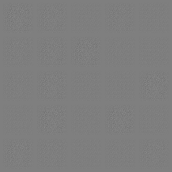

epoch: 0/300, batch: 10/600, G_loss: 0.9219481945037842, D_loss: (0.5102208852767944, 0.5079839825630188)
epoch: 0/300, batch: 20/600, G_loss: 1.3580502271652222, D_loss: (0.34354567527770996, 0.29768669605255127)
epoch: 0/300, batch: 30/600, G_loss: 1.8395408391952515, D_loss: (0.2094334214925766, 0.1736898422241211)
epoch: 0/300, batch: 40/600, G_loss: 2.2798635959625244, D_loss: (0.13188773393630981, 0.10884521156549454)
epoch: 0/300, batch: 50/600, G_loss: 2.631288528442383, D_loss: (0.08983558416366577, 0.07735973596572876)
epoch: 0/300, batch: 60/600, G_loss: 2.855137586593628, D_loss: (0.06665743142366409, 0.06500287353992462)
epoch: 0/300, batch: 70/600, G_loss: 3.2464356422424316, D_loss: (0.17653699219226837, 0.04175879433751106)
epoch: 0/300, batch: 80/600, G_loss: 3.214867353439331, D_loss: (0.05419408157467842, 0.04387836530804634)
epoch: 0/300, batch: 90/600, G_loss: 3.192004442214966, D_loss: (0.05622407793998718, 0.04905898496508598)
epoch: 0/300, batch: 100/600, G_loss

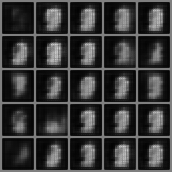

epoch: 0/300, batch: 110/600, G_loss: 2.0314722061157227, D_loss: (0.22072969377040863, 0.15312811732292175)
epoch: 0/300, batch: 120/600, G_loss: 2.668185234069824, D_loss: (0.10664626210927963, 0.07489805668592453)
epoch: 0/300, batch: 130/600, G_loss: 3.0742669105529785, D_loss: (0.06610069423913956, 0.05194015055894852)
epoch: 0/300, batch: 140/600, G_loss: 4.295302391052246, D_loss: (1.5002834796905518, 0.015918385237455368)
epoch: 0/300, batch: 150/600, G_loss: 2.1486570835113525, D_loss: (0.21959859132766724, 0.14540836215019226)
epoch: 0/300, batch: 160/600, G_loss: 2.7380356788635254, D_loss: (0.11680824309587479, 0.07406802475452423)
epoch: 0/300, batch: 170/600, G_loss: 2.910122871398926, D_loss: (0.08535610139369965, 0.06226803734898567)
epoch: 0/300, batch: 180/600, G_loss: 3.339052677154541, D_loss: (0.0487590916454792, 0.04481524974107742)
epoch: 0/300, batch: 190/600, G_loss: 3.064152717590332, D_loss: (0.06314767152070999, 0.06258060038089752)
epoch: 0/300, batch: 200/

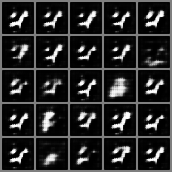

epoch: 0/300, batch: 210/600, G_loss: 0.7184755802154541, D_loss: (0.023398971185088158, 1.071876883506775)
epoch: 0/300, batch: 220/600, G_loss: 2.3801283836364746, D_loss: (0.20066235959529877, 0.14579245448112488)
epoch: 0/300, batch: 230/600, G_loss: 2.6576943397521973, D_loss: (0.13588616251945496, 0.12089236080646515)
epoch: 0/300, batch: 240/600, G_loss: 3.139235496520996, D_loss: (0.120263010263443, 0.06750138849020004)
epoch: 0/300, batch: 250/600, G_loss: 3.310914993286133, D_loss: (0.13191163539886475, 0.05351346358656883)
epoch: 0/300, batch: 260/600, G_loss: 3.079671621322632, D_loss: (0.0714942067861557, 0.06672632694244385)
epoch: 0/300, batch: 270/600, G_loss: 3.272747278213501, D_loss: (0.04995998367667198, 0.06125613674521446)
epoch: 0/300, batch: 280/600, G_loss: 4.4138102531433105, D_loss: (0.4970647394657135, 0.05078371986746788)
epoch: 0/300, batch: 290/600, G_loss: 2.3884363174438477, D_loss: (0.18380527198314667, 0.17886991798877716)
epoch: 0/300, batch: 300/600

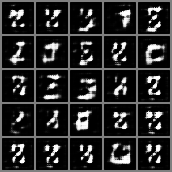

epoch: 0/300, batch: 310/600, G_loss: 2.712489604949951, D_loss: (0.09138906747102737, 0.17023992538452148)
epoch: 0/300, batch: 320/600, G_loss: 3.221592426300049, D_loss: (0.1446683257818222, 0.08441334962844849)
epoch: 0/300, batch: 330/600, G_loss: 3.9111168384552, D_loss: (0.08556455373764038, 0.05987383797764778)
epoch: 0/300, batch: 340/600, G_loss: 3.4193527698516846, D_loss: (0.19110098481178284, 0.09439533203840256)
epoch: 0/300, batch: 350/600, G_loss: 3.582900285720825, D_loss: (0.09341554343700409, 0.07518265396356583)
epoch: 0/300, batch: 360/600, G_loss: 2.970569133758545, D_loss: (0.043438054621219635, 0.17934200167655945)
epoch: 0/300, batch: 370/600, G_loss: 4.291468620300293, D_loss: (0.1337582916021347, 0.038011908531188965)
epoch: 0/300, batch: 380/600, G_loss: 3.0161025524139404, D_loss: (0.061669956892728806, 0.12446671724319458)
epoch: 0/300, batch: 390/600, G_loss: 3.3750391006469727, D_loss: (0.09817880392074585, 0.1010858342051506)
epoch: 0/300, batch: 400/60

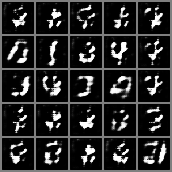

epoch: 0/300, batch: 410/600, G_loss: 4.490262985229492, D_loss: (0.12138815224170685, 0.04902443289756775)
epoch: 0/300, batch: 420/600, G_loss: 3.2663159370422363, D_loss: (0.044371072202920914, 0.13616357743740082)
epoch: 0/300, batch: 430/600, G_loss: 3.0731170177459717, D_loss: (0.19190211594104767, 0.09225626289844513)
epoch: 0/300, batch: 440/600, G_loss: 2.870866060256958, D_loss: (0.0627637729048729, 0.1727302521467209)
epoch: 0/300, batch: 450/600, G_loss: 3.785576581954956, D_loss: (0.11149225383996964, 0.057479456067085266)
epoch: 0/300, batch: 460/600, G_loss: 3.7203612327575684, D_loss: (0.05904335901141167, 0.09424274414777756)
epoch: 0/300, batch: 470/600, G_loss: 3.3306691646575928, D_loss: (0.056001707911491394, 0.09992339462041855)
epoch: 0/300, batch: 480/600, G_loss: 4.7608323097229, D_loss: (0.08625710755586624, 0.02153792232275009)
epoch: 0/300, batch: 490/600, G_loss: 3.7551076412200928, D_loss: (0.021805990487337112, 0.08913043886423111)
epoch: 0/300, batch: 50

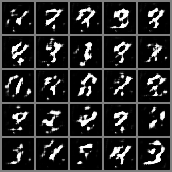

epoch: 0/300, batch: 510/600, G_loss: 3.9971225261688232, D_loss: (0.0337759368121624, 0.05519472062587738)
epoch: 0/300, batch: 520/600, G_loss: 4.47758674621582, D_loss: (0.1041022390127182, 0.03224016726016998)
epoch: 0/300, batch: 530/600, G_loss: 3.394812822341919, D_loss: (0.059981703758239746, 0.07505830377340317)
epoch: 0/300, batch: 540/600, G_loss: 3.0571346282958984, D_loss: (0.05374700576066971, 0.12465527653694153)
epoch: 0/300, batch: 550/600, G_loss: 3.485318660736084, D_loss: (0.05967371538281441, 0.0731632336974144)
epoch: 0/300, batch: 560/600, G_loss: 4.818063259124756, D_loss: (0.020275354385375977, 0.023601967841386795)
epoch: 0/300, batch: 570/600, G_loss: 4.594692230224609, D_loss: (0.03329339250922203, 0.018907466903328896)
epoch: 0/300, batch: 580/600, G_loss: 4.840664386749268, D_loss: (0.0346699133515358, 0.017210686579346657)
epoch: 0/300, batch: 590/600, G_loss: 4.600010871887207, D_loss: (0.03990410268306732, 0.02468474581837654)
epoch: 1/300, batch: 0/600

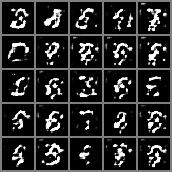

epoch: 1/300, batch: 10/600, G_loss: 5.5415191650390625, D_loss: (0.058356642723083496, 0.00919040571898222)
epoch: 1/300, batch: 20/600, G_loss: 4.757229804992676, D_loss: (0.008808493614196777, 0.023219650611281395)
epoch: 1/300, batch: 30/600, G_loss: 4.539905071258545, D_loss: (0.012805360369384289, 0.023101583123207092)
epoch: 1/300, batch: 40/600, G_loss: 4.77095890045166, D_loss: (0.01616870053112507, 0.019093208014965057)
epoch: 1/300, batch: 50/600, G_loss: 3.4860963821411133, D_loss: (0.012176573276519775, 0.08011481165885925)
epoch: 1/300, batch: 60/600, G_loss: 4.979717254638672, D_loss: (0.011810000985860825, 0.016354482620954514)
epoch: 1/300, batch: 70/600, G_loss: 4.592284679412842, D_loss: (0.004824667703360319, 0.032326918095350266)
epoch: 1/300, batch: 80/600, G_loss: 4.212915420532227, D_loss: (0.015503552742302418, 0.034795887768268585)
epoch: 1/300, batch: 90/600, G_loss: 5.219202995300293, D_loss: (0.027050238102674484, 0.011389282532036304)
epoch: 1/300, batch: 

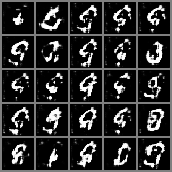

epoch: 1/300, batch: 110/600, G_loss: 4.675465106964111, D_loss: (0.168378546833992, 0.03075941652059555)
epoch: 1/300, batch: 120/600, G_loss: 3.3940212726593018, D_loss: (0.09226097911596298, 0.10253648459911346)
epoch: 1/300, batch: 130/600, G_loss: 4.0624895095825195, D_loss: (0.015596971847116947, 0.03279750421643257)
epoch: 1/300, batch: 140/600, G_loss: 4.783998966217041, D_loss: (0.024327771738171577, 0.014111064374446869)
epoch: 1/300, batch: 150/600, G_loss: 4.805555820465088, D_loss: (0.006799058988690376, 0.014376900158822536)
epoch: 1/300, batch: 160/600, G_loss: 6.228249549865723, D_loss: (0.01617678627371788, 0.003207652596756816)
epoch: 1/300, batch: 170/600, G_loss: 4.59669303894043, D_loss: (0.012668010778725147, 0.018945880234241486)
epoch: 1/300, batch: 180/600, G_loss: 4.073437690734863, D_loss: (0.005392841063439846, 0.030155276879668236)
epoch: 1/300, batch: 190/600, G_loss: 4.7586870193481445, D_loss: (0.0217202790081501, 0.014341498725116253)
epoch: 1/300, batc

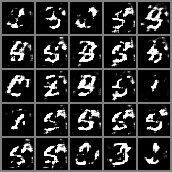

epoch: 1/300, batch: 210/600, G_loss: 3.9853098392486572, D_loss: (0.022241005674004555, 0.03376626595854759)
epoch: 1/300, batch: 220/600, G_loss: 4.403780460357666, D_loss: (0.009240117855370045, 0.02554173953831196)
epoch: 1/300, batch: 230/600, G_loss: 6.369556427001953, D_loss: (0.006430246401578188, 0.003865668084472418)
epoch: 1/300, batch: 240/600, G_loss: 6.260805606842041, D_loss: (0.014639017172157764, 0.004856212064623833)
epoch: 1/300, batch: 250/600, G_loss: 4.721302032470703, D_loss: (0.00957869365811348, 0.016346078366041183)
epoch: 1/300, batch: 260/600, G_loss: 5.678946018218994, D_loss: (0.008927597664296627, 0.005761182866990566)
epoch: 1/300, batch: 270/600, G_loss: 5.7638421058654785, D_loss: (0.008253402076661587, 0.005614395719021559)
epoch: 1/300, batch: 280/600, G_loss: 4.703045845031738, D_loss: (0.010657360777258873, 0.017834603786468506)
epoch: 1/300, batch: 290/600, G_loss: 5.03526496887207, D_loss: (0.004604320041835308, 0.01046318281441927)
epoch: 1/300,

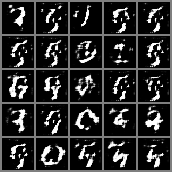

epoch: 1/300, batch: 310/600, G_loss: 6.162907600402832, D_loss: (0.01377711072564125, 0.0054219430312514305)
epoch: 1/300, batch: 320/600, G_loss: 5.351989269256592, D_loss: (0.007075465749949217, 0.015055142343044281)
epoch: 1/300, batch: 330/600, G_loss: 5.2246928215026855, D_loss: (0.021994750946760178, 0.01206812635064125)
epoch: 1/300, batch: 340/600, G_loss: 4.866684436798096, D_loss: (0.004440818913280964, 0.01553251501172781)
epoch: 1/300, batch: 350/600, G_loss: 7.3096489906311035, D_loss: (0.007837860845029354, 0.0012563508935272694)
epoch: 1/300, batch: 360/600, G_loss: 4.122562408447266, D_loss: (0.3222610056400299, 0.09234737604856491)
epoch: 1/300, batch: 370/600, G_loss: 3.5627317428588867, D_loss: (0.005617906339466572, 0.1041497215628624)
epoch: 1/300, batch: 380/600, G_loss: 4.7084269523620605, D_loss: (0.05926467850804329, 0.013808559626340866)
epoch: 1/300, batch: 390/600, G_loss: 5.745738506317139, D_loss: (0.199622243642807, 0.006739650387316942)
epoch: 1/300, ba

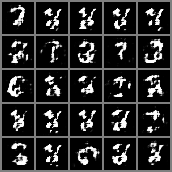

epoch: 1/300, batch: 410/600, G_loss: 5.338987827301025, D_loss: (0.010407979600131512, 0.008814897388219833)
epoch: 1/300, batch: 420/600, G_loss: 4.070494174957275, D_loss: (0.010347004979848862, 0.030822433531284332)
epoch: 1/300, batch: 430/600, G_loss: 5.1590118408203125, D_loss: (0.006688735447824001, 0.009893888607621193)
epoch: 1/300, batch: 440/600, G_loss: 4.900272369384766, D_loss: (0.008859587833285332, 0.0215616337954998)
epoch: 1/300, batch: 450/600, G_loss: 4.808481216430664, D_loss: (0.032999489456415176, 0.014704842120409012)
epoch: 1/300, batch: 460/600, G_loss: 6.069161891937256, D_loss: (0.021074365824460983, 0.003387547330930829)
epoch: 1/300, batch: 470/600, G_loss: 4.467396259307861, D_loss: (0.011410165578126907, 0.022880706936120987)
epoch: 1/300, batch: 480/600, G_loss: 5.2576904296875, D_loss: (0.008658635430037975, 0.00855075940489769)
epoch: 1/300, batch: 490/600, G_loss: 6.1282477378845215, D_loss: (0.013917893171310425, 0.003408063668757677)
epoch: 1/300,

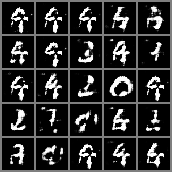

epoch: 1/300, batch: 510/600, G_loss: 5.821273326873779, D_loss: (0.00386988278478384, 0.005215869750827551)
epoch: 1/300, batch: 520/600, G_loss: 4.8253560066223145, D_loss: (0.01126465667039156, 0.013584353029727936)
epoch: 1/300, batch: 530/600, G_loss: 5.824794769287109, D_loss: (0.020790984854102135, 0.00456485990434885)
epoch: 1/300, batch: 540/600, G_loss: 4.641200065612793, D_loss: (0.0031486230436712503, 0.016103820875287056)
epoch: 1/300, batch: 550/600, G_loss: 5.261209487915039, D_loss: (0.0033329897560179234, 0.008304850198328495)
epoch: 1/300, batch: 560/600, G_loss: 4.154004096984863, D_loss: (0.022759562358260155, 0.02379085309803486)
epoch: 1/300, batch: 570/600, G_loss: 4.974607944488525, D_loss: (0.007303984370082617, 0.009848419576883316)
epoch: 1/300, batch: 580/600, G_loss: 6.397971153259277, D_loss: (0.010584777221083641, 0.002637251513078809)
epoch: 1/300, batch: 590/600, G_loss: 5.8875732421875, D_loss: (0.016097908839583397, 0.004390373360365629)
epoch: 2/300,

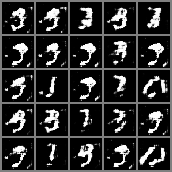

epoch: 2/300, batch: 10/600, G_loss: 4.590986728668213, D_loss: (0.011392503045499325, 0.01873736083507538)
epoch: 2/300, batch: 20/600, G_loss: 5.231110095977783, D_loss: (0.01886729896068573, 0.009463693015277386)
epoch: 2/300, batch: 30/600, G_loss: 3.3956971168518066, D_loss: (0.007485479116439819, 0.18025793135166168)
epoch: 2/300, batch: 40/600, G_loss: 2.7409021854400635, D_loss: (0.008155712857842445, 0.1334160715341568)
epoch: 2/300, batch: 50/600, G_loss: 3.9512624740600586, D_loss: (0.009234217926859856, 0.061227165162563324)
epoch: 2/300, batch: 60/600, G_loss: 4.8177409172058105, D_loss: (0.015604861080646515, 0.012658413499593735)
epoch: 2/300, batch: 70/600, G_loss: 4.499389171600342, D_loss: (0.00755771528929472, 0.019109884276986122)
epoch: 2/300, batch: 80/600, G_loss: 5.830939769744873, D_loss: (0.011913022957742214, 0.010411233641207218)
epoch: 2/300, batch: 90/600, G_loss: 7.50440788269043, D_loss: (0.11825110763311386, 0.003025038866326213)
epoch: 2/300, batch: 10

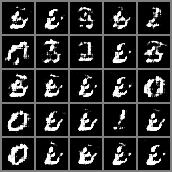

epoch: 2/300, batch: 110/600, G_loss: 4.924106597900391, D_loss: (0.31545552611351013, 0.012447969056665897)
epoch: 2/300, batch: 120/600, G_loss: 2.2026171684265137, D_loss: (0.016738804057240486, 0.2154565304517746)
epoch: 2/300, batch: 130/600, G_loss: 4.445796012878418, D_loss: (0.006871838588267565, 0.019885361194610596)
epoch: 2/300, batch: 140/600, G_loss: 4.312530517578125, D_loss: (0.009007077664136887, 0.024114718660712242)
epoch: 2/300, batch: 150/600, G_loss: 4.744968891143799, D_loss: (0.11581825464963913, 0.031830817461013794)
epoch: 2/300, batch: 160/600, G_loss: 4.574680328369141, D_loss: (0.020566260442137718, 0.018833976238965988)
epoch: 2/300, batch: 170/600, G_loss: 3.325620174407959, D_loss: (0.07106456160545349, 0.06818787753582001)
epoch: 2/300, batch: 180/600, G_loss: 4.152979850769043, D_loss: (0.009263279847800732, 0.03355405479669571)
epoch: 2/300, batch: 190/600, G_loss: 5.045427322387695, D_loss: (0.005298713222146034, 0.01192936860024929)
epoch: 2/300, bat

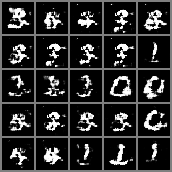

epoch: 2/300, batch: 210/600, G_loss: 4.544437408447266, D_loss: (0.012018921785056591, 0.024934574961662292)
epoch: 2/300, batch: 220/600, G_loss: 4.7697672843933105, D_loss: (0.01299242116510868, 0.016293330118060112)
epoch: 2/300, batch: 230/600, G_loss: 5.035074234008789, D_loss: (0.024555198848247528, 0.009764289483428001)
epoch: 2/300, batch: 240/600, G_loss: 5.473690986633301, D_loss: (0.006563934031873941, 0.01658117026090622)
epoch: 2/300, batch: 250/600, G_loss: 4.550240993499756, D_loss: (0.018733780831098557, 0.0203536469489336)
epoch: 2/300, batch: 260/600, G_loss: 3.732578754425049, D_loss: (0.004136663395911455, 0.038193345069885254)
epoch: 2/300, batch: 270/600, G_loss: 4.545285224914551, D_loss: (0.05055062845349312, 0.015949692577123642)
epoch: 2/300, batch: 280/600, G_loss: 2.4273438453674316, D_loss: (0.000992216751910746, 0.16800092160701752)
epoch: 2/300, batch: 290/600, G_loss: 5.766374111175537, D_loss: (0.0033718550112098455, 0.00567413168027997)
epoch: 2/300, 

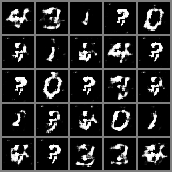

epoch: 2/300, batch: 310/600, G_loss: 4.512388706207275, D_loss: (0.011581036262214184, 0.02172807976603508)
epoch: 2/300, batch: 320/600, G_loss: 4.445667266845703, D_loss: (0.006485628895461559, 0.02220054343342781)
epoch: 2/300, batch: 330/600, G_loss: 3.7407655715942383, D_loss: (0.0018499779980629683, 0.04351944848895073)
epoch: 2/300, batch: 340/600, G_loss: 5.233282566070557, D_loss: (0.0016380554297938943, 0.00685540959239006)
epoch: 2/300, batch: 350/600, G_loss: 5.367091178894043, D_loss: (0.014753563329577446, 0.009454075247049332)
epoch: 2/300, batch: 360/600, G_loss: 4.777562141418457, D_loss: (0.050203803926706314, 0.06804957240819931)
epoch: 2/300, batch: 370/600, G_loss: 2.3317322731018066, D_loss: (0.0021082116290926933, 0.2060222029685974)
epoch: 2/300, batch: 380/600, G_loss: 2.9270999431610107, D_loss: (0.0025966016110032797, 0.10437152534723282)
epoch: 2/300, batch: 390/600, G_loss: 4.208857536315918, D_loss: (0.0078085060231387615, 0.027209315448999405)
epoch: 2/3

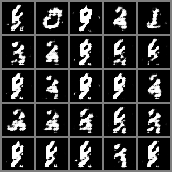

epoch: 2/300, batch: 410/600, G_loss: 4.334247589111328, D_loss: (0.003620833856984973, 0.029269346967339516)
epoch: 2/300, batch: 420/600, G_loss: 4.437140464782715, D_loss: (0.004661208484321833, 0.016252387315034866)
epoch: 2/300, batch: 430/600, G_loss: 4.795427322387695, D_loss: (0.23695127665996552, 0.059889402240514755)
epoch: 2/300, batch: 440/600, G_loss: 4.574455738067627, D_loss: (0.01866145059466362, 0.012598366476595402)
epoch: 2/300, batch: 450/600, G_loss: 4.975905895233154, D_loss: (0.0329420305788517, 0.009261132217943668)
epoch: 2/300, batch: 460/600, G_loss: 5.344355583190918, D_loss: (0.0183076374232769, 0.007173074409365654)
epoch: 2/300, batch: 470/600, G_loss: 3.1348965167999268, D_loss: (0.006053820718079805, 0.08841362595558167)
epoch: 2/300, batch: 480/600, G_loss: 4.338608264923096, D_loss: (0.002557916333898902, 0.017403919249773026)
epoch: 2/300, batch: 490/600, G_loss: 4.467935085296631, D_loss: (0.013891097158193588, 0.019671622663736343)
epoch: 2/300, ba

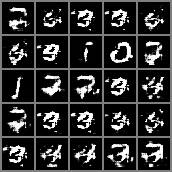

epoch: 2/300, batch: 510/600, G_loss: 4.4778242111206055, D_loss: (0.0067058103159070015, 0.01755991205573082)
epoch: 2/300, batch: 520/600, G_loss: 2.680790901184082, D_loss: (0.004006781615316868, 0.24035434424877167)
epoch: 2/300, batch: 530/600, G_loss: 4.83881139755249, D_loss: (0.014929110184311867, 0.05365119129419327)
epoch: 2/300, batch: 540/600, G_loss: 6.705803394317627, D_loss: (0.04030529409646988, 0.49174439907073975)
epoch: 2/300, batch: 550/600, G_loss: 5.170615196228027, D_loss: (0.061060987412929535, 0.017269467934966087)
epoch: 2/300, batch: 560/600, G_loss: 4.523664951324463, D_loss: (0.02325846441090107, 0.015191747806966305)
epoch: 2/300, batch: 570/600, G_loss: 4.813722610473633, D_loss: (0.007815498858690262, 0.013118583709001541)
epoch: 2/300, batch: 580/600, G_loss: 3.467780113220215, D_loss: (0.004017756786197424, 0.043783124536275864)
epoch: 2/300, batch: 590/600, G_loss: 4.679139137268066, D_loss: (0.003188188187777996, 0.016527630388736725)
epoch: 3/300, b

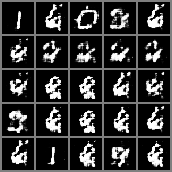

epoch: 3/300, batch: 10/600, G_loss: 5.625320911407471, D_loss: (0.06310772150754929, 0.0056582726538181305)
epoch: 3/300, batch: 20/600, G_loss: 4.018707752227783, D_loss: (0.06013062596321106, 0.03133576735854149)
epoch: 3/300, batch: 30/600, G_loss: 5.7274861335754395, D_loss: (0.009601512923836708, 0.006264508236199617)
epoch: 3/300, batch: 40/600, G_loss: 4.2963547706604, D_loss: (0.02172045037150383, 0.067410409450531)
epoch: 3/300, batch: 50/600, G_loss: 3.240182399749756, D_loss: (0.004450838081538677, 0.08960077911615372)
epoch: 3/300, batch: 60/600, G_loss: 5.1942572593688965, D_loss: (0.003309361869469285, 0.03685066103935242)
epoch: 3/300, batch: 70/600, G_loss: 5.684475898742676, D_loss: (0.008488411083817482, 0.004313905723392963)
epoch: 3/300, batch: 80/600, G_loss: 3.0530941486358643, D_loss: (0.011736215092241764, 0.2934395670890808)
epoch: 3/300, batch: 90/600, G_loss: 4.640570163726807, D_loss: (0.028162017464637756, 0.014237578958272934)
epoch: 3/300, batch: 100/600

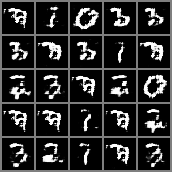

epoch: 3/300, batch: 110/600, G_loss: 3.314965009689331, D_loss: (0.07901111990213394, 0.07766780257225037)
epoch: 3/300, batch: 120/600, G_loss: 7.80098819732666, D_loss: (0.15875867009162903, 0.0017463311087340117)
epoch: 3/300, batch: 130/600, G_loss: 2.7116219997406006, D_loss: (0.009755599312484264, 0.10281756520271301)
epoch: 3/300, batch: 140/600, G_loss: 6.366281509399414, D_loss: (0.016991252079606056, 0.003282765857875347)
epoch: 3/300, batch: 150/600, G_loss: 5.99874210357666, D_loss: (0.040109504014253616, 0.0032489956356585026)
epoch: 3/300, batch: 160/600, G_loss: 10.079547882080078, D_loss: (0.3846586346626282, 0.00014584080781787634)
epoch: 3/300, batch: 170/600, G_loss: 7.495184898376465, D_loss: (0.22146423161029816, 0.001709056319668889)
epoch: 3/300, batch: 180/600, G_loss: 3.788630962371826, D_loss: (0.05279453843832016, 0.039873380213975906)
epoch: 3/300, batch: 190/600, G_loss: 4.2653584480285645, D_loss: (0.03908591344952583, 0.04030982032418251)
epoch: 3/300, b

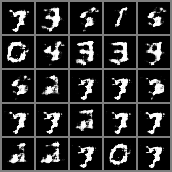

epoch: 3/300, batch: 210/600, G_loss: 9.373287200927734, D_loss: (0.39432433247566223, 0.0005613755201920867)
epoch: 3/300, batch: 220/600, G_loss: 2.469806432723999, D_loss: (0.008355088531970978, 0.14532984793186188)
epoch: 3/300, batch: 230/600, G_loss: 3.8753561973571777, D_loss: (0.009061820805072784, 0.03204574063420296)
epoch: 3/300, batch: 240/600, G_loss: 2.7629971504211426, D_loss: (0.04072383791208267, 0.13199569284915924)
epoch: 3/300, batch: 250/600, G_loss: 5.777108192443848, D_loss: (0.0034494497813284397, 0.006135731469839811)
epoch: 3/300, batch: 260/600, G_loss: 4.465435028076172, D_loss: (0.1120583638548851, 0.061306849122047424)
epoch: 3/300, batch: 270/600, G_loss: 3.5246245861053467, D_loss: (0.024088885635137558, 0.04538530483841896)
epoch: 3/300, batch: 280/600, G_loss: 4.5463385581970215, D_loss: (0.07920344173908234, 0.02319471538066864)
epoch: 3/300, batch: 290/600, G_loss: 2.1767139434814453, D_loss: (0.01416080817580223, 0.18547353148460388)
epoch: 3/300, b

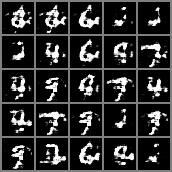

epoch: 3/300, batch: 310/600, G_loss: 3.4900174140930176, D_loss: (0.014625472947955132, 0.0688551813364029)
epoch: 3/300, batch: 320/600, G_loss: 3.397265911102295, D_loss: (0.00923237670212984, 0.05638677254319191)
epoch: 3/300, batch: 330/600, G_loss: 3.903916835784912, D_loss: (0.038093939423561096, 0.0516197495162487)
epoch: 3/300, batch: 340/600, G_loss: 7.865952014923096, D_loss: (0.001906369929201901, 0.013777329586446285)
epoch: 3/300, batch: 350/600, G_loss: 1.496978759765625, D_loss: (0.000738819595426321, 0.42452988028526306)
epoch: 3/300, batch: 360/600, G_loss: 2.367849826812744, D_loss: (0.03862661495804787, 0.1421760767698288)
epoch: 3/300, batch: 370/600, G_loss: 3.3758230209350586, D_loss: (0.009327891282737255, 0.0628810003399849)
epoch: 3/300, batch: 380/600, G_loss: 5.266966342926025, D_loss: (0.10463976114988327, 0.01123087015002966)
epoch: 3/300, batch: 390/600, G_loss: 8.665111541748047, D_loss: (0.0395500585436821, 0.0003463101456873119)
epoch: 3/300, batch: 40

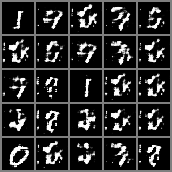

epoch: 3/300, batch: 410/600, G_loss: 2.999143123626709, D_loss: (0.007738273125141859, 0.098564513027668)
epoch: 3/300, batch: 420/600, G_loss: 4.848792552947998, D_loss: (0.13700518012046814, 0.01498745009303093)
epoch: 3/300, batch: 430/600, G_loss: 5.319196701049805, D_loss: (0.08878490328788757, 0.01318699587136507)
epoch: 3/300, batch: 440/600, G_loss: 2.5731170177459717, D_loss: (0.035832520574331284, 0.12512348592281342)
epoch: 3/300, batch: 450/600, G_loss: 4.348170757293701, D_loss: (0.01675231195986271, 0.021888528019189835)
epoch: 3/300, batch: 460/600, G_loss: 6.672481060028076, D_loss: (0.06453922390937805, 0.0026723623741418123)
epoch: 3/300, batch: 470/600, G_loss: 5.881565093994141, D_loss: (0.13526953756809235, 0.005203108303248882)
epoch: 3/300, batch: 480/600, G_loss: 7.9738240242004395, D_loss: (0.44649067521095276, 0.0005538088735193014)
epoch: 3/300, batch: 490/600, G_loss: 4.11453914642334, D_loss: (0.0901612788438797, 0.059256281703710556)
epoch: 3/300, batch: 

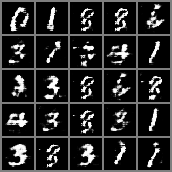

epoch: 3/300, batch: 510/600, G_loss: 1.9299285411834717, D_loss: (0.16615043580532074, 0.23837539553642273)
epoch: 3/300, batch: 520/600, G_loss: 4.62657356262207, D_loss: (0.01306308712810278, 0.022676320746541023)
epoch: 3/300, batch: 530/600, G_loss: 3.1699893474578857, D_loss: (0.029635805636644363, 0.10681717842817307)
epoch: 3/300, batch: 540/600, G_loss: 4.239850997924805, D_loss: (0.04505162686109543, 0.025202924385666847)
epoch: 3/300, batch: 550/600, G_loss: 9.847363471984863, D_loss: (0.008005566895008087, 0.00021937066048849374)
epoch: 3/300, batch: 560/600, G_loss: 10.325490951538086, D_loss: (0.41769447922706604, 8.988742774818093e-05)
epoch: 3/300, batch: 570/600, G_loss: 4.853415489196777, D_loss: (0.02567148022353649, 0.015005500055849552)
epoch: 3/300, batch: 580/600, G_loss: 7.94096565246582, D_loss: (1.3140565156936646, 0.0007697510882280767)
epoch: 3/300, batch: 590/600, G_loss: 6.938871383666992, D_loss: (0.16887621581554413, 0.0018085793126374483)
epoch: 4/300, 

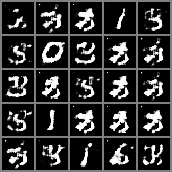

epoch: 4/300, batch: 10/600, G_loss: 10.413203239440918, D_loss: (0.14625734090805054, 7.69272301113233e-05)
epoch: 4/300, batch: 20/600, G_loss: 6.522845268249512, D_loss: (0.11611390858888626, 0.002405970823019743)
epoch: 4/300, batch: 30/600, G_loss: 2.5221686363220215, D_loss: (0.003538277465850115, 0.10621053725481033)
epoch: 4/300, batch: 40/600, G_loss: 5.645300388336182, D_loss: (0.15528684854507446, 0.008374410681426525)
epoch: 4/300, batch: 50/600, G_loss: 4.648744583129883, D_loss: (0.030523570254445076, 0.01763365976512432)
epoch: 4/300, batch: 60/600, G_loss: 5.423579216003418, D_loss: (0.008979413658380508, 0.00607885979115963)
epoch: 4/300, batch: 70/600, G_loss: 3.4549484252929688, D_loss: (0.05053374171257019, 0.04038272798061371)
epoch: 4/300, batch: 80/600, G_loss: 3.560152292251587, D_loss: (0.047231074422597885, 0.05441911146044731)
epoch: 4/300, batch: 90/600, G_loss: 4.055392265319824, D_loss: (0.03445259481668472, 0.02806253917515278)
epoch: 4/300, batch: 100/60

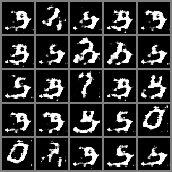

epoch: 4/300, batch: 110/600, G_loss: 4.841279983520508, D_loss: (0.09890106320381165, 0.01369678694754839)
epoch: 4/300, batch: 120/600, G_loss: 9.739224433898926, D_loss: (1.8335022926330566, 0.0004040174826513976)
epoch: 4/300, batch: 130/600, G_loss: 4.103135108947754, D_loss: (0.1102420836687088, 0.10371269285678864)
epoch: 4/300, batch: 140/600, G_loss: 3.6800615787506104, D_loss: (0.10292765498161316, 0.05780814588069916)
epoch: 4/300, batch: 150/600, G_loss: 0.36147117614746094, D_loss: (0.04067813232541084, 1.757623314857483)
epoch: 4/300, batch: 160/600, G_loss: 5.788733005523682, D_loss: (0.335402250289917, 0.006393055431544781)
epoch: 4/300, batch: 170/600, G_loss: 3.2229163646698, D_loss: (0.5666584372520447, 0.09609726816415787)
epoch: 4/300, batch: 180/600, G_loss: 1.9668679237365723, D_loss: (0.022309644147753716, 0.24976091086864471)
epoch: 4/300, batch: 190/600, G_loss: 2.857776165008545, D_loss: (0.19800682365894318, 0.08582216501235962)
epoch: 4/300, batch: 200/600,

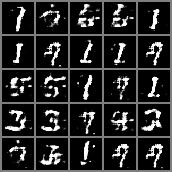

epoch: 4/300, batch: 210/600, G_loss: 2.023496627807617, D_loss: (0.08921043574810028, 0.22164887189865112)
epoch: 4/300, batch: 220/600, G_loss: 2.831160545349121, D_loss: (0.08482593297958374, 0.10254798829555511)
epoch: 4/300, batch: 230/600, G_loss: 1.345408320426941, D_loss: (0.19037467241287231, 0.537996768951416)
epoch: 4/300, batch: 240/600, G_loss: 0.8270530104637146, D_loss: (0.04142644256353378, 0.8800003528594971)
epoch: 4/300, batch: 250/600, G_loss: 2.3187012672424316, D_loss: (0.008243944495916367, 0.20035994052886963)
epoch: 4/300, batch: 260/600, G_loss: 6.0397796630859375, D_loss: (0.021315990015864372, 0.0038909357972443104)
epoch: 4/300, batch: 270/600, G_loss: 3.289008140563965, D_loss: (0.034279435873031616, 0.061485499143600464)
epoch: 4/300, batch: 280/600, G_loss: 5.184252738952637, D_loss: (0.47074252367019653, 0.009361703880131245)
epoch: 4/300, batch: 290/600, G_loss: 3.895972490310669, D_loss: (0.018048321828246117, 0.03657560050487518)
epoch: 4/300, batch:

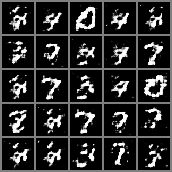

epoch: 4/300, batch: 310/600, G_loss: 2.349802017211914, D_loss: (0.06967823207378387, 0.19431810081005096)
epoch: 4/300, batch: 320/600, G_loss: 2.3278067111968994, D_loss: (0.04646061733365059, 0.17321830987930298)
epoch: 4/300, batch: 330/600, G_loss: 5.401536464691162, D_loss: (0.08719893544912338, 0.010244770906865597)
epoch: 4/300, batch: 340/600, G_loss: 7.558075428009033, D_loss: (0.5172936320304871, 0.0010052003199234605)
epoch: 4/300, batch: 350/600, G_loss: 4.22152853012085, D_loss: (0.2500883638858795, 0.03270716592669487)
epoch: 4/300, batch: 360/600, G_loss: 4.611911773681641, D_loss: (0.14996764063835144, 0.051283881068229675)
epoch: 4/300, batch: 370/600, G_loss: 1.9158530235290527, D_loss: (0.07812431454658508, 0.2228407859802246)
epoch: 4/300, batch: 380/600, G_loss: 4.362853527069092, D_loss: (0.10989543795585632, 0.07716523855924606)
epoch: 4/300, batch: 390/600, G_loss: 1.0020647048950195, D_loss: (0.06949975341558456, 0.8930971622467041)
epoch: 4/300, batch: 400/6

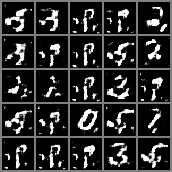

epoch: 4/300, batch: 410/600, G_loss: 2.4683523178100586, D_loss: (0.018658023327589035, 0.19931477308273315)
epoch: 4/300, batch: 420/600, G_loss: 4.791461944580078, D_loss: (0.12114831060171127, 0.01261548325419426)
epoch: 4/300, batch: 430/600, G_loss: 4.9319353103637695, D_loss: (0.030317995697259903, 0.012734429910779)
epoch: 4/300, batch: 440/600, G_loss: 2.8978748321533203, D_loss: (0.08365347981452942, 0.1154097393155098)
epoch: 4/300, batch: 450/600, G_loss: 3.031792402267456, D_loss: (0.05027979984879494, 0.1856490522623062)
epoch: 4/300, batch: 460/600, G_loss: 6.529700756072998, D_loss: (0.026421958580613136, 0.0047726682387292385)
epoch: 4/300, batch: 470/600, G_loss: 3.137197971343994, D_loss: (0.21771694719791412, 0.06677155941724777)
epoch: 4/300, batch: 480/600, G_loss: 2.2110862731933594, D_loss: (0.062447670847177505, 0.1725563257932663)
epoch: 4/300, batch: 490/600, G_loss: 4.162426471710205, D_loss: (0.0669984295964241, 0.031282439827919006)
epoch: 4/300, batch: 50

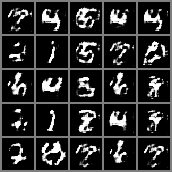

epoch: 4/300, batch: 510/600, G_loss: 5.244480609893799, D_loss: (0.8230443596839905, 0.012503750622272491)
epoch: 4/300, batch: 520/600, G_loss: 0.4991883933544159, D_loss: (0.01224973239004612, 1.2482237815856934)
epoch: 4/300, batch: 530/600, G_loss: 2.052704334259033, D_loss: (0.011563761159777641, 0.4092402160167694)
epoch: 4/300, batch: 540/600, G_loss: 5.56995964050293, D_loss: (0.1264639049768448, 0.007188079878687859)
epoch: 4/300, batch: 550/600, G_loss: 3.029914140701294, D_loss: (0.01683560572564602, 0.10922727733850479)
epoch: 4/300, batch: 560/600, G_loss: 7.376821517944336, D_loss: (0.025562234222888947, 0.0026016950141638517)
epoch: 4/300, batch: 570/600, G_loss: 4.507458686828613, D_loss: (0.016113124787807465, 0.03372465446591377)
epoch: 4/300, batch: 580/600, G_loss: 4.527621746063232, D_loss: (0.03841214254498482, 0.019196679815649986)
epoch: 4/300, batch: 590/600, G_loss: 3.6617937088012695, D_loss: (0.14054101705551147, 0.06274857372045517)
epoch: 5/300, batch: 0/

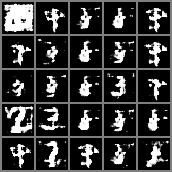

epoch: 5/300, batch: 10/600, G_loss: 9.162627220153809, D_loss: (0.22287702560424805, 0.00030480194254778326)
epoch: 5/300, batch: 20/600, G_loss: 4.6687469482421875, D_loss: (0.24426186084747314, 0.019517064094543457)
epoch: 5/300, batch: 30/600, G_loss: 11.231201171875, D_loss: (0.14576907455921173, 2.979975579364691e-05)
epoch: 5/300, batch: 40/600, G_loss: 2.399384021759033, D_loss: (0.0186014287173748, 0.17467378079891205)
epoch: 5/300, batch: 50/600, G_loss: 4.153852939605713, D_loss: (0.0741414725780487, 0.02339215762913227)
epoch: 5/300, batch: 60/600, G_loss: 3.8363986015319824, D_loss: (0.0101395845413208, 0.15938501060009003)
epoch: 5/300, batch: 70/600, G_loss: 1.6847704648971558, D_loss: (0.06829458475112915, 0.29838207364082336)
epoch: 5/300, batch: 80/600, G_loss: 3.8721261024475098, D_loss: (0.03221745789051056, 0.09515152126550674)
epoch: 5/300, batch: 90/600, G_loss: 1.1144345998764038, D_loss: (0.017205899581313133, 0.7474770545959473)
epoch: 5/300, batch: 100/600, G

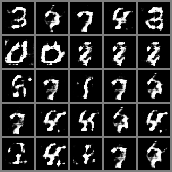

epoch: 5/300, batch: 110/600, G_loss: 1.2229092121124268, D_loss: (0.036753445863723755, 0.7704365253448486)
epoch: 5/300, batch: 120/600, G_loss: 5.3732428550720215, D_loss: (0.4830548167228699, 0.013262808322906494)
epoch: 5/300, batch: 130/600, G_loss: 2.3568532466888428, D_loss: (0.02239665575325489, 0.16678573191165924)
epoch: 5/300, batch: 140/600, G_loss: 9.783321380615234, D_loss: (0.2046312391757965, 0.0010064967209473252)
epoch: 5/300, batch: 150/600, G_loss: 5.641470432281494, D_loss: (0.08488569408655167, 0.012930098921060562)
epoch: 5/300, batch: 160/600, G_loss: 3.869678258895874, D_loss: (0.3431360721588135, 0.06889514625072479)
epoch: 5/300, batch: 170/600, G_loss: 4.3049445152282715, D_loss: (0.17287449538707733, 0.031346626579761505)
epoch: 5/300, batch: 180/600, G_loss: 2.059152126312256, D_loss: (0.03832031786441803, 0.23725129663944244)
epoch: 5/300, batch: 190/600, G_loss: 2.825394630432129, D_loss: (0.1981118619441986, 0.36400464177131653)
epoch: 5/300, batch: 20

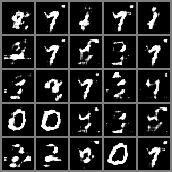

epoch: 5/300, batch: 210/600, G_loss: 2.2147326469421387, D_loss: (0.041486337780952454, 0.181461900472641)
epoch: 5/300, batch: 220/600, G_loss: 2.7698357105255127, D_loss: (0.017872776836156845, 0.26245248317718506)
epoch: 5/300, batch: 230/600, G_loss: 6.482707977294922, D_loss: (0.0935787558555603, 0.003768069436773658)
epoch: 5/300, batch: 240/600, G_loss: 3.311952829360962, D_loss: (0.014888153411448002, 0.07709185779094696)
epoch: 5/300, batch: 250/600, G_loss: 3.896394968032837, D_loss: (0.24409493803977966, 0.03584237024188042)
epoch: 5/300, batch: 260/600, G_loss: 2.092515468597412, D_loss: (0.07334022969007492, 0.2261056900024414)
epoch: 5/300, batch: 270/600, G_loss: 1.0919487476348877, D_loss: (0.010173916816711426, 0.5914981961250305)
epoch: 5/300, batch: 280/600, G_loss: 3.511112928390503, D_loss: (0.11060376465320587, 0.061945151537656784)
epoch: 5/300, batch: 290/600, G_loss: 3.736762285232544, D_loss: (0.1293477565050125, 0.0331340990960598)
epoch: 5/300, batch: 300/6

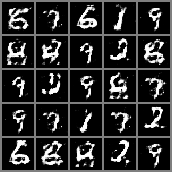

epoch: 5/300, batch: 310/600, G_loss: 3.99337100982666, D_loss: (0.059774354100227356, 0.03473503515124321)
epoch: 5/300, batch: 320/600, G_loss: 5.319591522216797, D_loss: (0.02200542762875557, 0.01133792195469141)
epoch: 5/300, batch: 330/600, G_loss: 3.9357237815856934, D_loss: (0.2457505166530609, 0.06343249976634979)
epoch: 5/300, batch: 340/600, G_loss: 4.504705429077148, D_loss: (0.2544233798980713, 0.018684346228837967)
epoch: 5/300, batch: 350/600, G_loss: 9.185017585754395, D_loss: (0.015123547054827213, 0.000172778673004359)
epoch: 5/300, batch: 360/600, G_loss: 7.096091270446777, D_loss: (0.06745973229408264, 0.002045219298452139)
epoch: 5/300, batch: 370/600, G_loss: 2.830301284790039, D_loss: (0.0160016231238842, 0.11588228493928909)
epoch: 5/300, batch: 380/600, G_loss: 10.205270767211914, D_loss: (1.317960500717163, 0.00013650814071297646)
epoch: 5/300, batch: 390/600, G_loss: 9.33166217803955, D_loss: (0.17283418774604797, 0.00040386506589129567)
epoch: 5/300, batch: 4

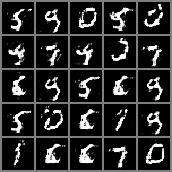

epoch: 5/300, batch: 410/600, G_loss: 4.784092426300049, D_loss: (0.004381794016808271, 0.01603170670568943)
epoch: 5/300, batch: 420/600, G_loss: 8.999734878540039, D_loss: (0.02604101598262787, 0.0003452888922765851)
epoch: 5/300, batch: 430/600, G_loss: 7.224855422973633, D_loss: (0.11268821358680725, 0.0016897334717214108)
epoch: 5/300, batch: 440/600, G_loss: 3.911069393157959, D_loss: (0.0792287141084671, 0.03953385725617409)
epoch: 5/300, batch: 450/600, G_loss: 3.276052951812744, D_loss: (0.01623792201280594, 0.08163534849882126)
epoch: 5/300, batch: 460/600, G_loss: 4.345434665679932, D_loss: (0.06558582186698914, 0.028948765248060226)
epoch: 5/300, batch: 470/600, G_loss: 3.2843542098999023, D_loss: (0.1946888118982315, 0.06843497604131699)
epoch: 5/300, batch: 480/600, G_loss: 1.664488673210144, D_loss: (0.006305794697254896, 0.31183314323425293)
epoch: 5/300, batch: 490/600, G_loss: 8.79529094696045, D_loss: (0.7829447388648987, 0.0007304410682991147)
epoch: 5/300, batch: 5

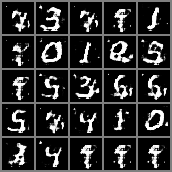

epoch: 5/300, batch: 510/600, G_loss: 1.1182169914245605, D_loss: (0.017527926713228226, 0.5519900918006897)
epoch: 5/300, batch: 520/600, G_loss: 7.329059600830078, D_loss: (0.11403021216392517, 0.0023639616556465626)
epoch: 5/300, batch: 530/600, G_loss: 2.6484458446502686, D_loss: (0.03230266273021698, 0.22777795791625977)
epoch: 5/300, batch: 540/600, G_loss: 3.1752588748931885, D_loss: (0.05944253131747246, 0.06584231555461884)
epoch: 5/300, batch: 550/600, G_loss: 5.663733959197998, D_loss: (0.09237482398748398, 0.014926149509847164)
epoch: 5/300, batch: 560/600, G_loss: 3.5802764892578125, D_loss: (0.0390729196369648, 0.05699381232261658)
epoch: 5/300, batch: 570/600, G_loss: 3.8096933364868164, D_loss: (0.042591504752635956, 0.037246223539114)
epoch: 5/300, batch: 580/600, G_loss: 6.468938827514648, D_loss: (0.012704048305749893, 0.0045957136899232864)
epoch: 5/300, batch: 590/600, G_loss: 1.8789902925491333, D_loss: (0.1327764242887497, 0.3002176880836487)
epoch: 6/300, batch:

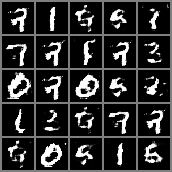

epoch: 6/300, batch: 10/600, G_loss: 3.3970468044281006, D_loss: (0.05138441175222397, 0.0454547218978405)
epoch: 6/300, batch: 20/600, G_loss: 4.169787406921387, D_loss: (0.035228438675403595, 0.023795247077941895)
epoch: 6/300, batch: 30/600, G_loss: 8.591826438903809, D_loss: (0.02955693006515503, 0.0004642836283892393)
epoch: 6/300, batch: 40/600, G_loss: 6.116293430328369, D_loss: (0.16836793720722198, 0.006707831751555204)
epoch: 6/300, batch: 50/600, G_loss: 3.929046392440796, D_loss: (0.0644916370511055, 0.027979200705885887)
epoch: 6/300, batch: 60/600, G_loss: 3.078251838684082, D_loss: (0.020138775929808617, 0.10183767974376678)
epoch: 6/300, batch: 70/600, G_loss: 2.7305753231048584, D_loss: (0.009424643591046333, 0.1611340492963791)
epoch: 6/300, batch: 80/600, G_loss: 4.306037425994873, D_loss: (0.014621073380112648, 0.05263941362500191)
epoch: 6/300, batch: 90/600, G_loss: 3.594543218612671, D_loss: (0.05474663898348808, 0.05022815614938736)
epoch: 6/300, batch: 100/600,

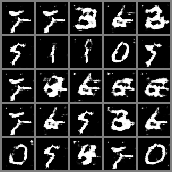

epoch: 6/300, batch: 110/600, G_loss: 2.7705132961273193, D_loss: (0.008398489095270634, 0.19355426728725433)
epoch: 6/300, batch: 120/600, G_loss: 3.1231820583343506, D_loss: (0.023312602192163467, 0.0844135656952858)
epoch: 6/300, batch: 130/600, G_loss: 8.654692649841309, D_loss: (0.7790077924728394, 0.00042596476851031184)
epoch: 6/300, batch: 140/600, G_loss: 3.2516982555389404, D_loss: (0.008962113410234451, 0.06054653972387314)
epoch: 6/300, batch: 150/600, G_loss: 2.791855573654175, D_loss: (0.019991036504507065, 0.09859906136989594)
epoch: 6/300, batch: 160/600, G_loss: 3.442349910736084, D_loss: (0.008723574690520763, 0.12165924906730652)
epoch: 6/300, batch: 170/600, G_loss: 4.3529229164123535, D_loss: (0.04599452391266823, 0.028805870562791824)
epoch: 6/300, batch: 180/600, G_loss: 3.4097979068756104, D_loss: (0.10081280022859573, 0.07576388120651245)
epoch: 6/300, batch: 190/600, G_loss: 7.832706451416016, D_loss: (0.1608496904373169, 0.0008723240462131798)
epoch: 6/300, b

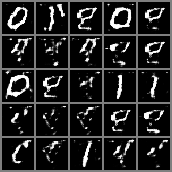

epoch: 6/300, batch: 210/600, G_loss: 3.5003609657287598, D_loss: (0.017199229449033737, 0.07130829989910126)
epoch: 6/300, batch: 220/600, G_loss: 2.189622402191162, D_loss: (0.03601273521780968, 0.2197837382555008)
epoch: 6/300, batch: 230/600, G_loss: 4.610345840454102, D_loss: (0.024089856073260307, 0.0205397792160511)
epoch: 6/300, batch: 240/600, G_loss: 3.534726142883301, D_loss: (0.007545114029198885, 0.06955017894506454)
epoch: 6/300, batch: 250/600, G_loss: 1.8871803283691406, D_loss: (0.003510033478960395, 0.25140249729156494)
epoch: 6/300, batch: 260/600, G_loss: 5.326026439666748, D_loss: (0.04563787579536438, 0.009315242990851402)
epoch: 6/300, batch: 270/600, G_loss: 3.5808463096618652, D_loss: (0.017112571746110916, 0.05226995795965195)
epoch: 6/300, batch: 280/600, G_loss: 8.012999534606934, D_loss: (0.37784343957901, 0.0013534390600398183)
epoch: 6/300, batch: 290/600, G_loss: 7.249659538269043, D_loss: (0.09567105025053024, 0.0032811854034662247)
epoch: 6/300, batch:

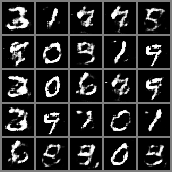

epoch: 6/300, batch: 310/600, G_loss: 9.262914657592773, D_loss: (0.4063185751438141, 0.00019011939002666622)
epoch: 6/300, batch: 320/600, G_loss: 9.26952075958252, D_loss: (0.09423218667507172, 0.0001994410704355687)
epoch: 6/300, batch: 330/600, G_loss: 3.1830015182495117, D_loss: (0.03768531233072281, 0.07123322039842606)
epoch: 6/300, batch: 340/600, G_loss: 1.398032546043396, D_loss: (0.005490189418196678, 0.7158811688423157)
epoch: 6/300, batch: 350/600, G_loss: 7.894016265869141, D_loss: (0.3327009975910187, 0.002145264996215701)
epoch: 6/300, batch: 360/600, G_loss: 6.660421848297119, D_loss: (0.04706825688481331, 0.0045789568684995174)
epoch: 6/300, batch: 370/600, G_loss: 4.046938896179199, D_loss: (0.025855904445052147, 0.043177880346775055)
epoch: 6/300, batch: 380/600, G_loss: 4.037516117095947, D_loss: (0.08967902511358261, 0.03281430900096893)
epoch: 6/300, batch: 390/600, G_loss: 1.8343586921691895, D_loss: (0.03658397123217583, 0.25215640664100647)
epoch: 6/300, batch

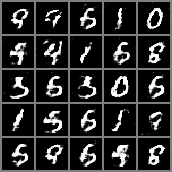

epoch: 6/300, batch: 410/600, G_loss: 3.509565830230713, D_loss: (0.029134418815374374, 0.0656154602766037)
epoch: 6/300, batch: 420/600, G_loss: 2.409717321395874, D_loss: (0.11972174048423767, 0.1705198734998703)
epoch: 6/300, batch: 430/600, G_loss: 3.882556200027466, D_loss: (0.08236464858055115, 0.035574112087488174)
epoch: 6/300, batch: 440/600, G_loss: 4.165587425231934, D_loss: (0.21192583441734314, 0.028058908879756927)
epoch: 6/300, batch: 450/600, G_loss: 10.363208770751953, D_loss: (1.9960289001464844, 0.0002055923396255821)
epoch: 6/300, batch: 460/600, G_loss: 8.234397888183594, D_loss: (0.03323274850845337, 0.0005676344153471291)
epoch: 6/300, batch: 470/600, G_loss: 11.937871932983398, D_loss: (0.3075096607208252, 1.1521820852067322e-05)
epoch: 6/300, batch: 480/600, G_loss: 3.2780416011810303, D_loss: (0.08530046790838242, 0.07161784917116165)
epoch: 6/300, batch: 490/600, G_loss: 4.136749744415283, D_loss: (0.2830711901187897, 0.029093168675899506)
epoch: 6/300, batch

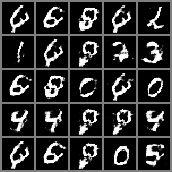

epoch: 6/300, batch: 510/600, G_loss: 1.6149498224258423, D_loss: (0.011049114167690277, 0.32833972573280334)
epoch: 6/300, batch: 520/600, G_loss: 2.397667169570923, D_loss: (0.03500386327505112, 0.15279340744018555)
epoch: 6/300, batch: 530/600, G_loss: 2.7728781700134277, D_loss: (0.025360021740198135, 0.14637310802936554)
epoch: 6/300, batch: 540/600, G_loss: 5.331412315368652, D_loss: (0.03704269230365753, 0.01111055538058281)
epoch: 6/300, batch: 550/600, G_loss: 1.9230237007141113, D_loss: (0.008178013376891613, 0.7632089257240295)
epoch: 6/300, batch: 560/600, G_loss: 9.589384078979492, D_loss: (1.1520994901657104, 0.0005169459618628025)
epoch: 6/300, batch: 570/600, G_loss: 4.950709819793701, D_loss: (0.0963883101940155, 0.012230264022946358)
epoch: 6/300, batch: 580/600, G_loss: 10.038962364196777, D_loss: (0.023958411067724228, 0.00010994742478942499)
epoch: 6/300, batch: 590/600, G_loss: 3.1269280910491943, D_loss: (0.037733931094408035, 0.09739869087934494)
epoch: 7/300, b

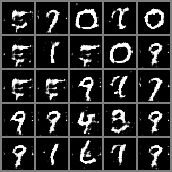

epoch: 7/300, batch: 10/600, G_loss: 0.8051392436027527, D_loss: (0.010897373780608177, 0.7884246706962585)
epoch: 7/300, batch: 20/600, G_loss: 1.9242432117462158, D_loss: (0.005076715722680092, 0.4599972069263458)
epoch: 7/300, batch: 30/600, G_loss: 6.404246807098389, D_loss: (0.04031341150403023, 0.0038642084691673517)
epoch: 7/300, batch: 40/600, G_loss: 5.1850080490112305, D_loss: (0.3264620304107666, 0.008387533016502857)
epoch: 7/300, batch: 50/600, G_loss: 2.719489336013794, D_loss: (0.0150882164016366, 0.10675499588251114)
epoch: 7/300, batch: 60/600, G_loss: 1.8234672546386719, D_loss: (0.006997399963438511, 0.41283169388771057)
epoch: 7/300, batch: 70/600, G_loss: 8.112281799316406, D_loss: (0.21116751432418823, 0.0008894529310055077)
epoch: 7/300, batch: 80/600, G_loss: 4.255021572113037, D_loss: (0.07419442385435104, 0.04842214286327362)
epoch: 7/300, batch: 90/600, G_loss: 4.2445878982543945, D_loss: (0.03258148953318596, 0.03849385678768158)
epoch: 7/300, batch: 100/600

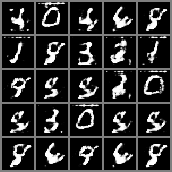

epoch: 7/300, batch: 110/600, G_loss: 2.964266777038574, D_loss: (0.05064444988965988, 0.09499668329954147)
epoch: 7/300, batch: 120/600, G_loss: 4.920881271362305, D_loss: (0.06999948620796204, 0.011862930841743946)
epoch: 7/300, batch: 130/600, G_loss: 6.283955097198486, D_loss: (0.2463265210390091, 0.0036278185434639454)
epoch: 7/300, batch: 140/600, G_loss: 5.4285759925842285, D_loss: (0.07573185861110687, 0.012395104393362999)
epoch: 7/300, batch: 150/600, G_loss: 3.188197612762451, D_loss: (0.032156940549612045, 0.05936942994594574)
epoch: 7/300, batch: 160/600, G_loss: 0.9694516658782959, D_loss: (0.0079574603587389, 0.7537015676498413)
epoch: 7/300, batch: 170/600, G_loss: 3.7196478843688965, D_loss: (0.022756211459636688, 0.04635343700647354)
epoch: 7/300, batch: 180/600, G_loss: 9.087220191955566, D_loss: (0.01212245225906372, 0.00023678710567764938)
epoch: 7/300, batch: 190/600, G_loss: 7.205313682556152, D_loss: (0.29677191376686096, 0.001495337812229991)
epoch: 7/300, batc

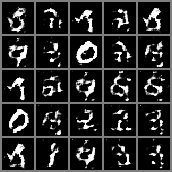

epoch: 7/300, batch: 210/600, G_loss: 6.412960052490234, D_loss: (0.007059672847390175, 0.0036643543280661106)
epoch: 7/300, batch: 220/600, G_loss: 2.1254401206970215, D_loss: (0.005782211199402809, 0.1838614046573639)
epoch: 7/300, batch: 230/600, G_loss: 7.9578776359558105, D_loss: (0.038064610213041306, 0.0007732486119493842)
epoch: 7/300, batch: 240/600, G_loss: 8.648110389709473, D_loss: (0.06599736958742142, 0.00041405190131627023)
epoch: 7/300, batch: 250/600, G_loss: 5.521254062652588, D_loss: (0.015927724540233612, 0.009304714389145374)
epoch: 7/300, batch: 260/600, G_loss: 8.713223457336426, D_loss: (0.0982280895113945, 0.00056589295854792)
epoch: 7/300, batch: 270/600, G_loss: 4.29098653793335, D_loss: (0.21354389190673828, 0.025297265499830246)
epoch: 7/300, batch: 280/600, G_loss: 5.184743881225586, D_loss: (0.016298547387123108, 0.01441376656293869)
epoch: 7/300, batch: 290/600, G_loss: 4.290836334228516, D_loss: (0.004182131495326757, 0.07461148500442505)
epoch: 7/300, 

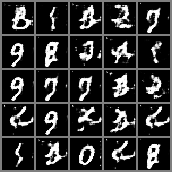

epoch: 7/300, batch: 310/600, G_loss: 3.562986373901367, D_loss: (0.05275323987007141, 0.06468084454536438)
epoch: 7/300, batch: 320/600, G_loss: 2.3971543312072754, D_loss: (0.00023379737103823572, 0.18468885123729706)
epoch: 7/300, batch: 330/600, G_loss: 7.905404567718506, D_loss: (0.0060298144817352295, 0.001960205379873514)
epoch: 7/300, batch: 340/600, G_loss: 6.187455654144287, D_loss: (0.062404610216617584, 0.00327915302477777)
epoch: 7/300, batch: 350/600, G_loss: 4.323742389678955, D_loss: (0.04012100398540497, 0.045220524072647095)
epoch: 7/300, batch: 360/600, G_loss: 3.4910056591033936, D_loss: (0.035706814378499985, 0.06526942551136017)
epoch: 7/300, batch: 370/600, G_loss: 6.083724498748779, D_loss: (0.029025603085756302, 0.0076169706881046295)
epoch: 7/300, batch: 380/600, G_loss: 4.103845596313477, D_loss: (0.11880593001842499, 0.026402795687317848)
epoch: 7/300, batch: 390/600, G_loss: 7.541309833526611, D_loss: (0.09356287121772766, 0.0017041248502209783)
epoch: 7/30

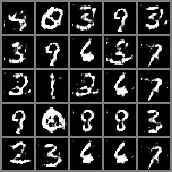

epoch: 7/300, batch: 410/600, G_loss: 6.434640884399414, D_loss: (0.10992136597633362, 0.0030892477370798588)
epoch: 7/300, batch: 420/600, G_loss: 4.837328910827637, D_loss: (0.03088587522506714, 0.014763424172997475)
epoch: 7/300, batch: 430/600, G_loss: 4.757744789123535, D_loss: (0.041959282010793686, 0.026725981384515762)
epoch: 7/300, batch: 440/600, G_loss: 4.1462883949279785, D_loss: (0.030941929668188095, 0.025322409346699715)
epoch: 7/300, batch: 450/600, G_loss: 7.134456634521484, D_loss: (1.1521230936050415, 0.0030091810040175915)
epoch: 7/300, batch: 460/600, G_loss: 7.960648059844971, D_loss: (0.23897169530391693, 0.0007013888098299503)
epoch: 7/300, batch: 470/600, G_loss: 2.9846606254577637, D_loss: (0.026850923895835876, 0.09477182477712631)
epoch: 7/300, batch: 480/600, G_loss: 7.296940326690674, D_loss: (0.032190944999456406, 0.002442788565531373)
epoch: 7/300, batch: 490/600, G_loss: 5.400633335113525, D_loss: (0.0704154372215271, 0.02629803493618965)
epoch: 7/300, 

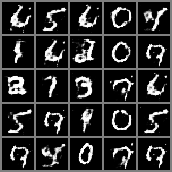

epoch: 7/300, batch: 510/600, G_loss: 4.935498237609863, D_loss: (0.0024722309317439795, 0.01979651115834713)
epoch: 7/300, batch: 520/600, G_loss: 7.991462230682373, D_loss: (0.9411251544952393, 0.0011749997502192855)
epoch: 7/300, batch: 530/600, G_loss: 7.9950408935546875, D_loss: (0.19672368466854095, 0.0008904979331418872)
epoch: 7/300, batch: 540/600, G_loss: 2.8631527423858643, D_loss: (0.007071985397487879, 0.22207997739315033)
epoch: 7/300, batch: 550/600, G_loss: 7.791261672973633, D_loss: (0.35017308592796326, 0.001589456689544022)
epoch: 7/300, batch: 560/600, G_loss: 2.4715681076049805, D_loss: (0.024293549358844757, 0.1454993188381195)
epoch: 7/300, batch: 570/600, G_loss: 3.4257047176361084, D_loss: (0.014228928834199905, 0.05683950334787369)
epoch: 7/300, batch: 580/600, G_loss: 5.317173480987549, D_loss: (0.5112316012382507, 0.009701787494122982)
epoch: 7/300, batch: 590/600, G_loss: 1.860749363899231, D_loss: (0.02933574840426445, 0.28838059306144714)
epoch: 8/300, ba

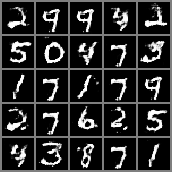

epoch: 8/300, batch: 10/600, G_loss: 7.6180925369262695, D_loss: (0.07701656222343445, 0.002849660813808441)
epoch: 8/300, batch: 20/600, G_loss: 0.30820325016975403, D_loss: (0.02602340467274189, 1.9438068866729736)
epoch: 8/300, batch: 30/600, G_loss: 1.949717402458191, D_loss: (0.03474696725606918, 0.2517338991165161)
epoch: 8/300, batch: 40/600, G_loss: 3.799631357192993, D_loss: (0.10625731199979782, 0.056809403002262115)
epoch: 8/300, batch: 50/600, G_loss: 1.936535358428955, D_loss: (0.020095495507121086, 0.22439521551132202)
epoch: 8/300, batch: 60/600, G_loss: 4.203382968902588, D_loss: (0.08940060436725616, 0.038525309413671494)
epoch: 8/300, batch: 70/600, G_loss: 6.667658805847168, D_loss: (0.014797921292483807, 0.003164834575727582)
epoch: 8/300, batch: 80/600, G_loss: 3.030958890914917, D_loss: (0.00727608660236001, 0.10075917840003967)
epoch: 8/300, batch: 90/600, G_loss: 6.947000503540039, D_loss: (0.024316130205988884, 0.001975690247491002)
epoch: 8/300, batch: 100/600

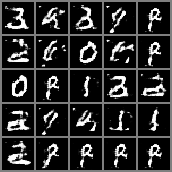

epoch: 8/300, batch: 110/600, G_loss: 4.7906904220581055, D_loss: (0.019326919689774513, 0.022803895175457)
epoch: 8/300, batch: 120/600, G_loss: 3.1797757148742676, D_loss: (0.010235757566988468, 0.06409567594528198)
epoch: 8/300, batch: 130/600, G_loss: 6.2481303215026855, D_loss: (0.0406341589987278, 0.003631492145359516)
epoch: 8/300, batch: 140/600, G_loss: 6.511501312255859, D_loss: (0.07822871953248978, 0.002661344362422824)
epoch: 8/300, batch: 150/600, G_loss: 2.3653485774993896, D_loss: (0.02788764424622059, 0.17428243160247803)
epoch: 8/300, batch: 160/600, G_loss: 1.8462861776351929, D_loss: (0.010233360342681408, 0.3773169219493866)
epoch: 8/300, batch: 170/600, G_loss: 14.414677619934082, D_loss: (1.6442207098007202, 3.5566836231737398e-06)
epoch: 8/300, batch: 180/600, G_loss: 5.482862949371338, D_loss: (0.07631933689117432, 0.009210588410496712)
epoch: 8/300, batch: 190/600, G_loss: 3.0646185874938965, D_loss: (0.041748352348804474, 0.07128441333770752)
epoch: 8/300, ba

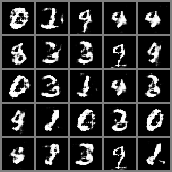

epoch: 8/300, batch: 210/600, G_loss: 2.313568115234375, D_loss: (0.004483261611312628, 0.3961453139781952)
epoch: 8/300, batch: 220/600, G_loss: 5.021442890167236, D_loss: (0.052904095500707626, 0.011521534062922001)
epoch: 8/300, batch: 230/600, G_loss: 4.228209972381592, D_loss: (0.11586466431617737, 0.023975927382707596)
epoch: 8/300, batch: 240/600, G_loss: 4.5798869132995605, D_loss: (0.003997089806944132, 0.07576752454042435)
epoch: 8/300, batch: 250/600, G_loss: 2.5609076023101807, D_loss: (0.00345704797655344, 0.41691887378692627)
epoch: 8/300, batch: 260/600, G_loss: 5.3781514167785645, D_loss: (0.055027857422828674, 0.008609358221292496)
epoch: 8/300, batch: 270/600, G_loss: 4.580087661743164, D_loss: (0.03153035044670105, 0.017214210703969002)
epoch: 8/300, batch: 280/600, G_loss: 7.00973653793335, D_loss: (0.046126242727041245, 0.0018385200528427958)
epoch: 8/300, batch: 290/600, G_loss: 6.282352447509766, D_loss: (0.05119882896542549, 0.004021817818284035)
epoch: 8/300, b

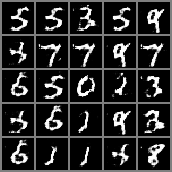

epoch: 8/300, batch: 310/600, G_loss: 9.741082191467285, D_loss: (0.059575095772743225, 0.00037617847556248307)
epoch: 8/300, batch: 320/600, G_loss: 2.3521292209625244, D_loss: (0.03153679519891739, 0.1861318200826645)
epoch: 8/300, batch: 330/600, G_loss: 5.019741058349609, D_loss: (0.03961838781833649, 0.02004176191985607)
epoch: 8/300, batch: 340/600, G_loss: 4.913924217224121, D_loss: (0.03914102911949158, 0.015345726162195206)
epoch: 8/300, batch: 350/600, G_loss: 12.206607818603516, D_loss: (0.4946211576461792, 2.5105677195824683e-05)
epoch: 8/300, batch: 360/600, G_loss: 1.131203055381775, D_loss: (0.028407281264662743, 0.7058795094490051)
epoch: 8/300, batch: 370/600, G_loss: 2.3501224517822266, D_loss: (0.18880249559879303, 0.15396521985530853)
epoch: 8/300, batch: 380/600, G_loss: 7.853639125823975, D_loss: (0.22761978209018707, 0.0022040822077542543)
epoch: 8/300, batch: 390/600, G_loss: 2.4023618698120117, D_loss: (0.010690356604754925, 0.14403505623340607)
epoch: 8/300, b

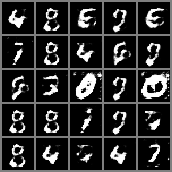

epoch: 8/300, batch: 410/600, G_loss: 6.083611965179443, D_loss: (0.1275707185268402, 0.012016497552394867)
epoch: 8/300, batch: 420/600, G_loss: 6.9614362716674805, D_loss: (0.2788499593734741, 0.01163584552705288)
epoch: 8/300, batch: 430/600, G_loss: 6.787922382354736, D_loss: (0.1903604120016098, 0.0017616816330701113)
epoch: 8/300, batch: 440/600, G_loss: 5.296762466430664, D_loss: (0.02827395126223564, 0.007629771251231432)
epoch: 8/300, batch: 450/600, G_loss: 2.8507080078125, D_loss: (0.02085624262690544, 0.12221287935972214)
epoch: 8/300, batch: 460/600, G_loss: 2.573958396911621, D_loss: (0.012372908182442188, 0.11992798745632172)
epoch: 8/300, batch: 470/600, G_loss: 5.278913974761963, D_loss: (0.06564968079328537, 0.009496123529970646)
epoch: 8/300, batch: 480/600, G_loss: 6.975569248199463, D_loss: (0.018781471997499466, 0.0015340819954872131)
epoch: 8/300, batch: 490/600, G_loss: 6.02725076675415, D_loss: (0.00670959334820509, 0.005522574298083782)
epoch: 8/300, batch: 50

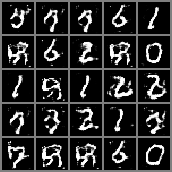

epoch: 8/300, batch: 510/600, G_loss: 4.386959552764893, D_loss: (0.021205652505159378, 0.019980857148766518)
epoch: 8/300, batch: 520/600, G_loss: 2.981015205383301, D_loss: (0.0027706155087798834, 0.09673386812210083)
epoch: 8/300, batch: 530/600, G_loss: 6.705811023712158, D_loss: (0.013152088969945908, 0.002533559687435627)
epoch: 8/300, batch: 540/600, G_loss: 2.8911936283111572, D_loss: (0.002397263655439019, 0.10526356101036072)
epoch: 8/300, batch: 550/600, G_loss: 6.79684591293335, D_loss: (0.26736876368522644, 0.0021721040830016136)
epoch: 8/300, batch: 560/600, G_loss: 2.646275281906128, D_loss: (0.02663034200668335, 0.09715165942907333)
epoch: 8/300, batch: 570/600, G_loss: 3.298205852508545, D_loss: (0.08645190298557281, 0.13210707902908325)
epoch: 8/300, batch: 580/600, G_loss: 3.3837461471557617, D_loss: (0.0016211806796491146, 0.11033231765031815)
epoch: 8/300, batch: 590/600, G_loss: 2.4143598079681396, D_loss: (0.029590167105197906, 0.14655503630638123)
epoch: 9/300, 

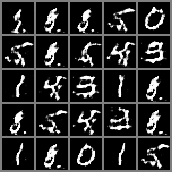

epoch: 9/300, batch: 10/600, G_loss: 1.4090321063995361, D_loss: (0.03884827718138695, 0.3678826093673706)
epoch: 9/300, batch: 20/600, G_loss: 3.233935832977295, D_loss: (0.013306951150298119, 0.06493748724460602)
epoch: 9/300, batch: 30/600, G_loss: 3.9169180393218994, D_loss: (0.006788998376578093, 0.031102724373340607)
epoch: 9/300, batch: 40/600, G_loss: 3.8983099460601807, D_loss: (0.0034916666336357594, 0.03196852654218674)
epoch: 9/300, batch: 50/600, G_loss: 6.6890411376953125, D_loss: (0.02688833884894848, 0.0020561739802360535)
epoch: 9/300, batch: 60/600, G_loss: 3.2793936729431152, D_loss: (0.017099998891353607, 0.05147258937358856)
epoch: 9/300, batch: 70/600, G_loss: 2.2891271114349365, D_loss: (0.008396696299314499, 0.17031964659690857)
epoch: 9/300, batch: 80/600, G_loss: 2.924715995788574, D_loss: (0.0029144976288080215, 0.08904381841421127)
epoch: 9/300, batch: 90/600, G_loss: 4.008217811584473, D_loss: (0.005167203024029732, 0.2413901537656784)
epoch: 9/300, batch: 

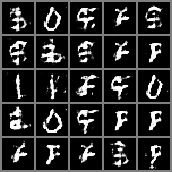

epoch: 9/300, batch: 110/600, G_loss: 3.8265695571899414, D_loss: (0.08281419426202774, 0.03979162871837616)
epoch: 9/300, batch: 120/600, G_loss: 2.960986614227295, D_loss: (0.03663700446486473, 0.08131273090839386)
epoch: 9/300, batch: 130/600, G_loss: 3.0764212608337402, D_loss: (0.02115924097597599, 0.06193557381629944)
epoch: 9/300, batch: 140/600, G_loss: 5.203615665435791, D_loss: (0.03205567225813866, 0.009298523887991905)
epoch: 9/300, batch: 150/600, G_loss: 1.6773099899291992, D_loss: (0.023102035745978355, 0.457579642534256)
epoch: 9/300, batch: 160/600, G_loss: 1.8686107397079468, D_loss: (0.0022577045019716024, 0.37266167998313904)
epoch: 9/300, batch: 170/600, G_loss: 4.229689121246338, D_loss: (0.01525470893830061, 0.025768816471099854)
epoch: 9/300, batch: 180/600, G_loss: 4.754966735839844, D_loss: (0.004363452084362507, 0.02633434347808361)
epoch: 9/300, batch: 190/600, G_loss: 2.149193048477173, D_loss: (0.013977378606796265, 0.21025319397449493)
epoch: 9/300, batch

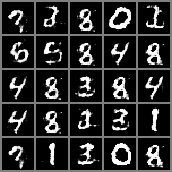

epoch: 9/300, batch: 210/600, G_loss: 8.030238151550293, D_loss: (0.007641310803592205, 0.0008982638828456402)
epoch: 9/300, batch: 220/600, G_loss: 2.2327685356140137, D_loss: (0.05008825659751892, 0.19323456287384033)
epoch: 9/300, batch: 230/600, G_loss: 4.517451286315918, D_loss: (0.03923894092440605, 0.016227595508098602)
epoch: 9/300, batch: 240/600, G_loss: 5.209489822387695, D_loss: (0.06427235156297684, 0.010860192589461803)
epoch: 9/300, batch: 250/600, G_loss: 1.6266981363296509, D_loss: (0.001844503334723413, 0.5172429084777832)
epoch: 9/300, batch: 260/600, G_loss: 1.7032912969589233, D_loss: (0.00985377561300993, 0.3755929172039032)
epoch: 9/300, batch: 270/600, G_loss: 2.6377522945404053, D_loss: (0.019503934308886528, 0.12769867479801178)
epoch: 9/300, batch: 280/600, G_loss: 2.308134078979492, D_loss: (0.03977559879422188, 0.1797591745853424)
epoch: 9/300, batch: 290/600, G_loss: 5.906008720397949, D_loss: (0.020621901378035545, 0.0055464887991547585)
epoch: 9/300, bat

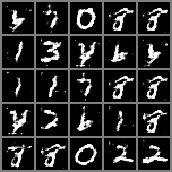

epoch: 9/300, batch: 310/600, G_loss: 4.552448749542236, D_loss: (0.08355896174907684, 0.04512074962258339)
epoch: 9/300, batch: 320/600, G_loss: 4.063310146331787, D_loss: (0.031812120229005814, 0.04075200483202934)
epoch: 9/300, batch: 330/600, G_loss: 4.820533752441406, D_loss: (0.00449166726320982, 0.018087008967995644)
epoch: 9/300, batch: 340/600, G_loss: 8.505154609680176, D_loss: (0.0206858329474926, 0.0007537971250712872)
epoch: 9/300, batch: 350/600, G_loss: 3.718395471572876, D_loss: (0.02396824210882187, 0.05801139771938324)
epoch: 9/300, batch: 360/600, G_loss: 3.7497003078460693, D_loss: (0.01972387731075287, 0.0846393033862114)
epoch: 9/300, batch: 370/600, G_loss: 11.304821968078613, D_loss: (0.07521834224462509, 0.00012100205640308559)
epoch: 9/300, batch: 380/600, G_loss: 4.740451812744141, D_loss: (0.045218728482723236, 0.013675735332071781)
epoch: 9/300, batch: 390/600, G_loss: 4.7678093910217285, D_loss: (0.02249021828174591, 0.016618913039565086)
epoch: 9/300, bat

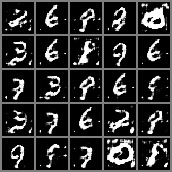

epoch: 9/300, batch: 410/600, G_loss: 4.2254252433776855, D_loss: (0.01809038780629635, 0.03695734217762947)
epoch: 9/300, batch: 420/600, G_loss: 5.7395758628845215, D_loss: (0.015619226731359959, 0.004554292652755976)
epoch: 9/300, batch: 430/600, G_loss: 5.200258731842041, D_loss: (0.04216022789478302, 0.010450317524373531)
epoch: 9/300, batch: 440/600, G_loss: 1.036647915840149, D_loss: (0.001149007468484342, 0.6985892653465271)
epoch: 9/300, batch: 450/600, G_loss: 2.962080955505371, D_loss: (0.04303384944796562, 0.09296028316020966)
epoch: 9/300, batch: 460/600, G_loss: 7.9893364906311035, D_loss: (0.275412380695343, 0.0006133660790510476)
epoch: 9/300, batch: 470/600, G_loss: 14.704036712646484, D_loss: (0.0617590993642807, 1.9324370441609062e-06)
epoch: 9/300, batch: 480/600, G_loss: 8.489143371582031, D_loss: (0.1995592713356018, 0.0003460598236415535)
epoch: 9/300, batch: 490/600, G_loss: 2.9835879802703857, D_loss: (0.03643244877457619, 0.16360816359519958)
epoch: 9/300, bat

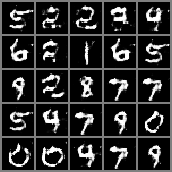

epoch: 9/300, batch: 510/600, G_loss: 4.5939226150512695, D_loss: (0.07324513792991638, 0.10678457468748093)
epoch: 9/300, batch: 520/600, G_loss: 2.699321985244751, D_loss: (0.12798981368541718, 0.11991915851831436)
epoch: 9/300, batch: 530/600, G_loss: 2.776010513305664, D_loss: (0.08483921736478806, 0.16053585708141327)
epoch: 9/300, batch: 540/600, G_loss: 3.5645480155944824, D_loss: (0.003550770925357938, 0.17147992551326752)
epoch: 9/300, batch: 550/600, G_loss: 4.23851203918457, D_loss: (0.1812412589788437, 0.09234071522951126)
epoch: 9/300, batch: 560/600, G_loss: 4.777525424957275, D_loss: (0.059270650148391724, 0.021099397912621498)
epoch: 9/300, batch: 570/600, G_loss: 5.3612751960754395, D_loss: (0.19858001172542572, 0.007774895057082176)
epoch: 9/300, batch: 580/600, G_loss: 0.8785341382026672, D_loss: (0.016645872965455055, 0.7888076901435852)
epoch: 9/300, batch: 590/600, G_loss: 2.916036605834961, D_loss: (0.008230509236454964, 0.1093643456697464)
epoch: 10/300, batch: 

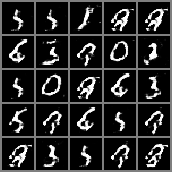

epoch: 10/300, batch: 10/600, G_loss: 2.606874942779541, D_loss: (0.038941990584135056, 0.11935413628816605)
epoch: 10/300, batch: 20/600, G_loss: 3.4612131118774414, D_loss: (0.01000918261706829, 0.06183161586523056)
epoch: 10/300, batch: 30/600, G_loss: 4.405826091766357, D_loss: (0.0074750883504748344, 0.11016290634870529)
epoch: 10/300, batch: 40/600, G_loss: 5.507378578186035, D_loss: (0.049743346869945526, 0.007891521789133549)
epoch: 10/300, batch: 50/600, G_loss: 6.1435394287109375, D_loss: (0.03113768808543682, 0.005251383874565363)
epoch: 10/300, batch: 60/600, G_loss: 8.726827621459961, D_loss: (0.04310251772403717, 0.00037541010533459485)
epoch: 10/300, batch: 70/600, G_loss: 4.060802459716797, D_loss: (0.0007598472875542939, 0.0516071543097496)
epoch: 10/300, batch: 80/600, G_loss: 2.4466817378997803, D_loss: (0.009959762915968895, 0.14693109691143036)
epoch: 10/300, batch: 90/600, G_loss: 6.645183563232422, D_loss: (0.10374913364648819, 0.0029004134703427553)
epoch: 10/30

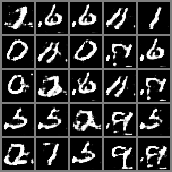

epoch: 10/300, batch: 110/600, G_loss: 3.812023878097534, D_loss: (0.007552272640168667, 0.036238893866539)
epoch: 10/300, batch: 120/600, G_loss: 2.973270893096924, D_loss: (0.03577617555856705, 0.08486157655715942)
epoch: 10/300, batch: 130/600, G_loss: 4.136136054992676, D_loss: (0.0025826662313193083, 0.02740328386425972)
epoch: 10/300, batch: 140/600, G_loss: 4.043889999389648, D_loss: (0.010783437639474869, 0.03898552805185318)
epoch: 10/300, batch: 150/600, G_loss: 5.008481025695801, D_loss: (0.04177294671535492, 0.01109748799353838)
epoch: 10/300, batch: 160/600, G_loss: 5.383810520172119, D_loss: (0.009185715578496456, 0.007495365105569363)
epoch: 10/300, batch: 170/600, G_loss: 9.69434928894043, D_loss: (0.010369310155510902, 0.00012286874698475003)
epoch: 10/300, batch: 180/600, G_loss: 2.756998062133789, D_loss: (0.0028682411648333073, 0.1514730602502823)
epoch: 10/300, batch: 190/600, G_loss: 4.494903087615967, D_loss: (0.016697896644473076, 0.023535901680588722)
epoch: 10

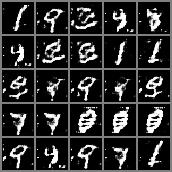

epoch: 10/300, batch: 210/600, G_loss: 8.664495468139648, D_loss: (0.1237013041973114, 0.0007872980204410851)
epoch: 10/300, batch: 220/600, G_loss: 4.799542427062988, D_loss: (0.018584782257676125, 0.01233078446239233)
epoch: 10/300, batch: 230/600, G_loss: 9.690361022949219, D_loss: (0.04199518263339996, 0.00013939211203251034)
epoch: 10/300, batch: 240/600, G_loss: 5.117351055145264, D_loss: (0.07787024974822998, 0.007944720797240734)
epoch: 10/300, batch: 250/600, G_loss: 2.513761520385742, D_loss: (0.011451223865151405, 0.14375203847885132)
epoch: 10/300, batch: 260/600, G_loss: 6.865789890289307, D_loss: (0.0034987672697752714, 0.0024704306852072477)
epoch: 10/300, batch: 270/600, G_loss: 3.3135385513305664, D_loss: (0.011137097142636776, 0.10313330590724945)
epoch: 10/300, batch: 280/600, G_loss: 6.4391398429870605, D_loss: (0.3131386637687683, 0.0022888476960361004)
epoch: 10/300, batch: 290/600, G_loss: 6.776403903961182, D_loss: (0.018621649593114853, 0.005565223749727011)
ep

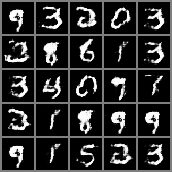

epoch: 10/300, batch: 310/600, G_loss: 5.774038791656494, D_loss: (0.1915491223335266, 0.008828986436128616)
epoch: 10/300, batch: 320/600, G_loss: 6.0363640785217285, D_loss: (0.09989722073078156, 0.00650542788207531)
epoch: 10/300, batch: 330/600, G_loss: 9.562506675720215, D_loss: (0.08976653218269348, 0.0004801601462531835)
epoch: 10/300, batch: 340/600, G_loss: 11.916406631469727, D_loss: (0.1632486879825592, 5.402866372605786e-05)
epoch: 10/300, batch: 350/600, G_loss: 7.890857696533203, D_loss: (0.07784494757652283, 0.000820996705442667)
epoch: 10/300, batch: 360/600, G_loss: 7.4735846519470215, D_loss: (0.36626091599464417, 0.0015926550840958953)
epoch: 10/300, batch: 370/600, G_loss: 5.614019870758057, D_loss: (0.02925724722445011, 0.008418494835495949)
epoch: 10/300, batch: 380/600, G_loss: 4.351571083068848, D_loss: (0.012225466780364513, 0.018221324309706688)
epoch: 10/300, batch: 390/600, G_loss: 4.399990081787109, D_loss: (0.008618522435426712, 0.05312143638730049)
epoch:

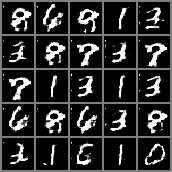

epoch: 10/300, batch: 410/600, G_loss: 4.7078776359558105, D_loss: (0.0025056281592696905, 0.015441213734447956)
epoch: 10/300, batch: 420/600, G_loss: 6.805211067199707, D_loss: (0.0769534781575203, 0.0016197941731661558)
epoch: 10/300, batch: 430/600, G_loss: 3.228926181793213, D_loss: (0.17560707032680511, 0.05249093472957611)
epoch: 10/300, batch: 440/600, G_loss: 6.765888690948486, D_loss: (0.14764995872974396, 0.005179817788302898)
epoch: 10/300, batch: 450/600, G_loss: 2.94704008102417, D_loss: (0.0328926257789135, 0.08525672554969788)
epoch: 10/300, batch: 460/600, G_loss: 3.7138357162475586, D_loss: (0.19676093757152557, 0.045092836022377014)
epoch: 10/300, batch: 470/600, G_loss: 8.632258415222168, D_loss: (0.26673635840415955, 0.0006768434541299939)
epoch: 10/300, batch: 480/600, G_loss: 1.3968069553375244, D_loss: (0.010984445922076702, 0.44067755341529846)
epoch: 10/300, batch: 490/600, G_loss: 1.1400476694107056, D_loss: (0.005214983597397804, 0.6904665231704712)
epoch: 1

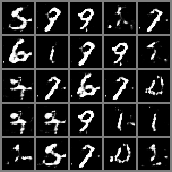

epoch: 10/300, batch: 510/600, G_loss: 6.919331073760986, D_loss: (0.007167004980146885, 0.0018504724139347672)
epoch: 10/300, batch: 520/600, G_loss: 8.50674057006836, D_loss: (0.2929258346557617, 0.00047070696018636227)
epoch: 10/300, batch: 530/600, G_loss: 4.059422016143799, D_loss: (0.013504535891115665, 0.030165504664182663)
epoch: 10/300, batch: 540/600, G_loss: 5.991687774658203, D_loss: (0.013672083616256714, 0.0036737294867634773)
epoch: 10/300, batch: 550/600, G_loss: 4.349710464477539, D_loss: (0.02222765050828457, 0.01952938362956047)
epoch: 10/300, batch: 560/600, G_loss: 2.830798387527466, D_loss: (0.026289332658052444, 0.10453467071056366)
epoch: 10/300, batch: 570/600, G_loss: 2.7421951293945312, D_loss: (0.12497977167367935, 0.1687334030866623)
epoch: 10/300, batch: 580/600, G_loss: 6.799882888793945, D_loss: (0.028942685574293137, 0.003920822869986296)
epoch: 10/300, batch: 590/600, G_loss: 4.158373832702637, D_loss: (0.09055155515670776, 0.023196332156658173)


KeyboardInterrupt: ignored

In [0]:
for epoch in range(num_epochs):
  
    # Train epoch
    for n_batch, (real_samples, labels) in enumerate(data_loader):
        
        # Prepare batch data
        real_samples, labels = Variable(real_samples).cuda(), labels.cuda()

          
        # Update model weights
        loss_g, loss_d = model.step_optimization(real_samples, labels)
        
        # Show current loss
        if (n_batch) % 10 == 0:
            print(f"epoch: {epoch}/{num_epochs}, batch: {n_batch}/{len(data_loader)}, G_loss: {loss_g}, D_loss: {loss_d}")    
          
        # Show fake samples
        if (n_batch) % 100 == 0:
            val_fake_samples = model.generate_samples(num_val_samples, z=z_val, labels = labels[0:num_val_samples]).data.cpu()
            display_batch_images(val_fake_samples)

tensor([9, 4, 1, 3, 2, 0, 0, 1, 9, 3, 6, 9, 0, 8, 9, 8, 1, 3, 3, 4, 6, 0, 4, 7,
        5])


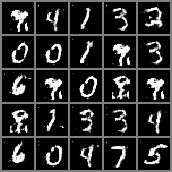

In [0]:
i = iter(data_loader)
t, l = next(i)

print(l[0:25])

val_fake_samples = model.generate_samples(25, z=z_val, labels = l[:25]).data.cpu()
display_batch_images(val_fake_samples)